Things to test:
- Smaller window (2-3 coulomb peak)
  Z[50:150, 20:120]. If it has a transition, check that it still finds a transition
  -> This works pretty good but determining the gradient becomes more uncertain.
- Lower resolution (e.g.60x60 points, decimation)
  Z[20:120:5, 20:120:5] Adds a 5x decimation (only use every 5th)
- Add noise
  Z + alpha *np.random.uniform(Z.size) adds noise with magnitude alpha
  
Feel free to combine multiple tests

FILTERING DISCUSSION:
filtering Z prior seems to lose information but also could really help mitigate noise
filtering theta seems to help increase contrast in transiion gradient matrices
filtering transition gradient matrices doesn't seem to be good for anything at the moment... but we'll see, i won't rule it out.

Deleting transitions needs to fully black out transitions for proper operation. Additionally, crossing transitions need to be accounted for.
Transgrad needs to be calculated more carefully. 


Plan:
- Fine tune and edit existing code
- Get a simple sweep going for multiple capacitance tests

In [279]:
import qcodes as qc
import numpy as np
import math
from scipy import signal
conv2 = signal.convolve2d
peaks = signal.find_peaks
pi = math.pi

In [280]:
#qc.data.data_set.DataSet.default_io.base_location = r'/Users/Dennis/Documents/Uni/ThesisB/Jupyter'
data = qc.load_data('CSD/2018-03-26/#004_4D_DC_TGAC_DBL_DBR_14-51-19')
data

DataSet:
   location = 'CSD/2018-03-26/#004_4D_DC_TGAC_DBL_DBR_14-51-19'
   <Type>   | <array_id>          | <array.name> | <array.shape>
   Setpoint | DC_control_DFR_set  | DFR          | (3,)
   Setpoint | DC_control_DFL_set  | DFL          | (3, 3)
   Setpoint | DBL_DBR_set         | DBL_DBR      | (3, 3, 301)
   Setpoint | DC_control_TGAC_set | TGAC         | (3, 3, 301, 251)
   Measured | DC_voltage          | DC_voltage   | (3, 3, 301, 251)

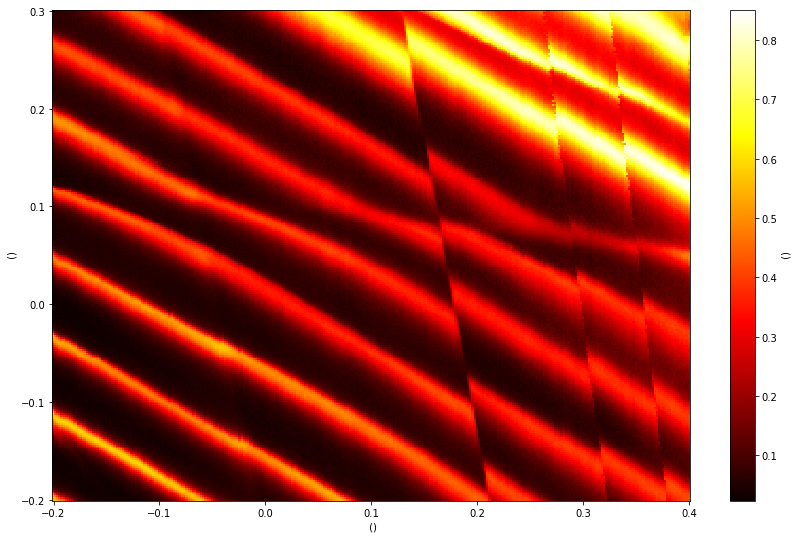

In [281]:
# importing data
x = data.DBL_DBR_set[1,1,:]
y = data.DC_control_TGAC_set[1,1,1,:]
Z = data.DC_voltage[0,2,:,:] #change these values for different datasets
#00 none 
#01 one clear
#02 three clear
#10 four clear
#11 five messy
#12 seven ok clarity. See this one for two transitions crossing clearly
#20 five messy at end
#21 six messy
#22 seven clearish
Z = np.swapaxes(Z,0,1)
    
#reduced sample size
#still works fine at locating, but determining gradient becomes less accurate
#x = x[151:301]
#y = y[0:125]
#Z = Z[0:125,151:301]

# decimation
#works fine locating up to 3x decimation. gradient becomes less accurate
#dec = 3;
#x = x[0:300:dec] 
#y = y[0:250:dec]
#Z = Z[0:250:dec,0:300:dec]

#Add noise
#filtering does clear this up BUT this outlines an issue with calculating transgrad.
#transgrad needs to take into account the relative maximums. otherwise noise greatly interferes. Improving transgrad
#calculations will make the system much more reliable
#alpha = 0.05
#Z = Z + alpha*np.random.uniform(-1,1,size=Z.shape)

plot = qc.MatPlot(Z,x=x,y=y,  figsize=(12,8))
#0.408
#0.203 #0.367 on 20 due to scanning error
#seems to work better in the centre of the image
#nonetheless, this works fully on all sample data. I hope it is not very overfitted

[{'grad_err%': 2.5015634771732298,
  'gradient': -6.125,
  'intensity': 0.93061224489795924,
  'location': 205},
 {'grad_err%': 3.3370411568409364,
  'gradient': -8.1666666666666661,
  'intensity': 0.91836734693877553,
  'location': 261},
 {'grad_err%': 3.8518518518518565,
  'gradient': -9.4230769230769234,
  'intensity': 0.90204081632653066,
  'location': 289}]

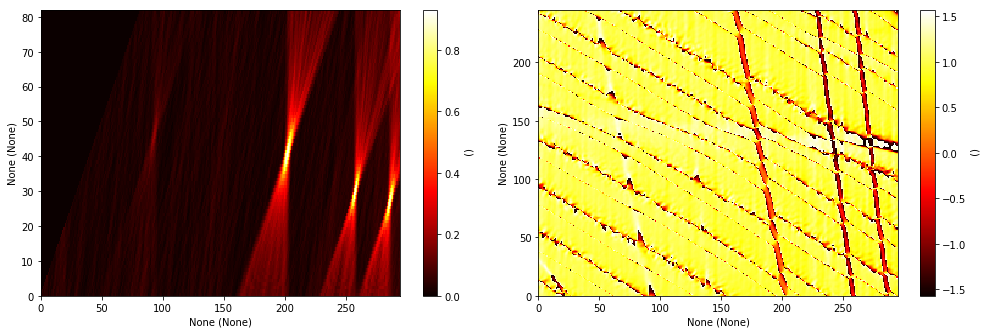

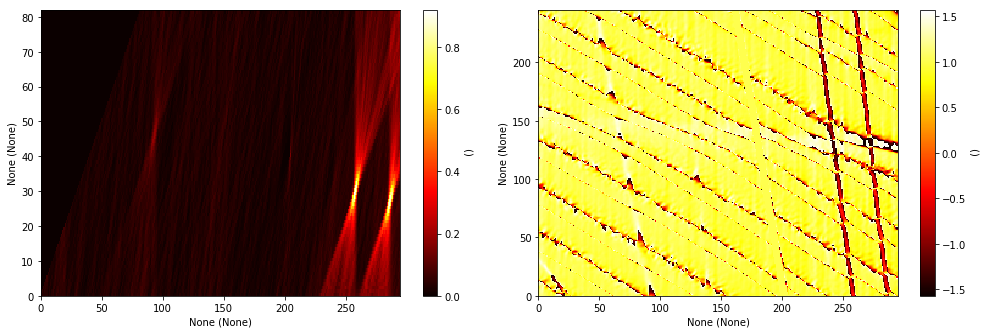

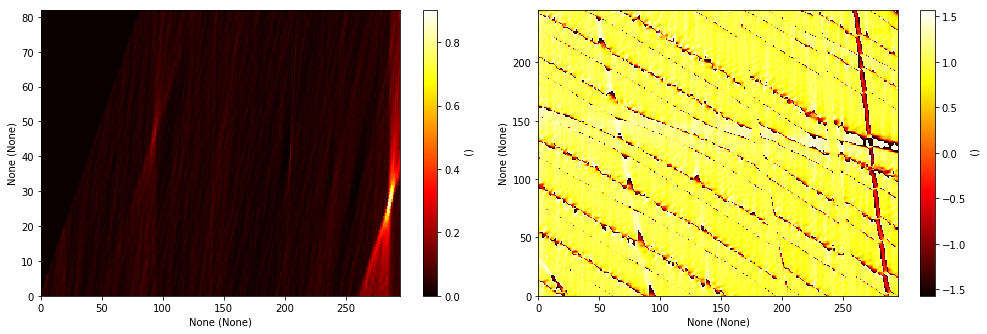

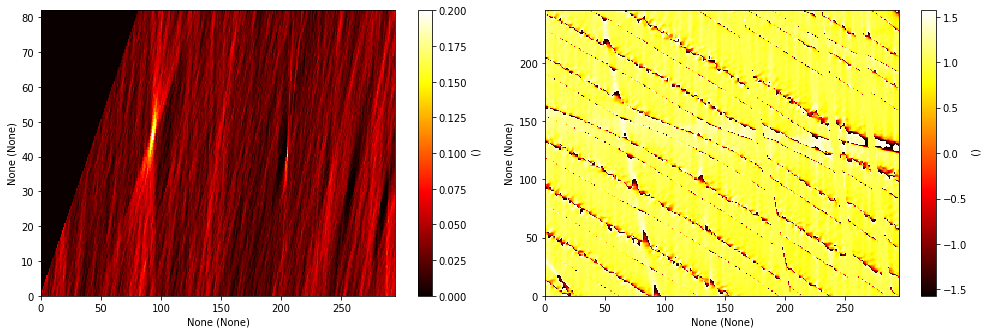

In [282]:
#%%timeit
transitions = find_transitions(Z,x,y, trueunits=False, chargetransfer=False, plots=True)
transitions

#timing done with 0,2
#2.94s reduced calc_transgrad
#3.38s reduced delete_trans
#4.09s reduced transgrad range
#8.16s full range
#-8.3, -8.89, -5.93

0.93061224489795924

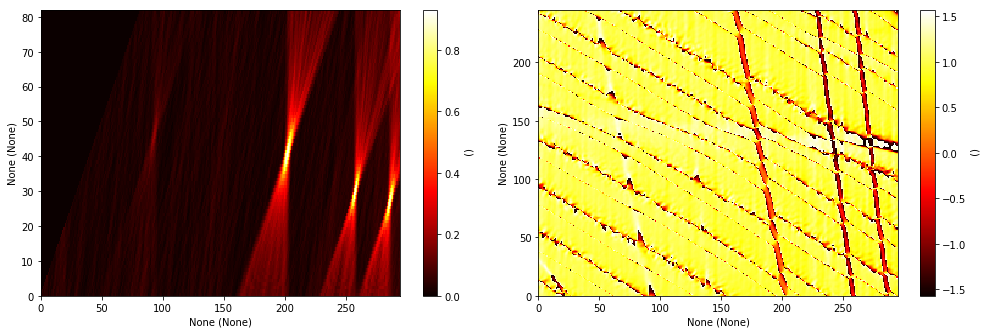

In [289]:
#use this to demonstrate how the program works
theta = calc_theta(Z, filter=True)
theta_mode = find_mode(theta)
transgrad = calc_transgrad(theta)
plot = qc.MatPlot(transgrad, theta, figsize=(14,5))
np.max(transgrad)

0.15102040816326534

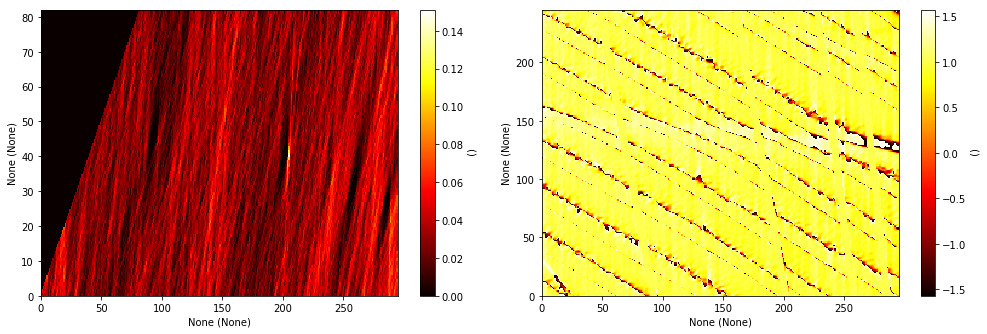

In [293]:
#run this multiple times to step through the process
I = max_index(transgrad)
location = I[1]
gradient = I[0]
theta = delete_trans(theta, location, gradient)
transgrad = calc_transgrad(theta)
plot = qc.MatPlot(transgrad, theta, figsize=(14,5))
np.max(transgrad)

In [110]:
def calc_theta(Z, filter = False):
    """
    Computes the theta matrix for a given 2-dimensional charge stability diagram.
    The theta matrix indicates the direction of the 2-dimensional gradient.

    Args:
        Z  (numpy.ndarray): 2-dimensional charge stability diagram matrix.
        filter      (bool): Enables filtering during the calculations.

    Returns:
        theta  (numpy.ndarray): 2-dimensional theta matrix.
    """
    
    ### Filter coefficients
    # filter for S before
    xSfil = np.array([[1], [2], [1]])
    ySfil = np.array([[1, 2, 1]])
    
    # filter for G after (not used currently)
    xGfil = np.array([[1], [2], [1]])
    yGfil = np.array([[1, 2, 1]])
    Gfil  = conv2(xGfil,yGfil)
    
    # filter for Z before (not used currently)
    #xZfil = np.array([[1], [4], [6], [4], [1]])
    #yZfil = np.array([[1, 4, 6, 4, 1]])
    xZfil = np.array([[1], [2], [1]])
    yZfil = np.array([[1, 2, 1]])
    Zfil  = conv2(xZfil,yZfil)
    
    
    # Sobel Operator
    SY = np.array([[1], [0], [-1]])
    SY = conv2(SY,ySfil)
    
    SX = np.array([[1, 0, -1]])
    SX = conv2(SX,xSfil)
    
    if(filter == True):
        Z = conv2(Z, Zfil, mode='valid')
    
    GY = conv2(Z, SY, mode='valid')
    
    GX = conv2(Z, SX, mode='valid')
    
    if(filter == True):
        GY = conv2(GY, Gfil, mode='valid')
        GX = conv2(GX, Gfil, mode='valid')
    
    #this isnt even used
    #G = (GX**2 + GY**2)**0.5;
    
    theta = np.arctan(GY/GX)
    return theta

In [217]:
def calc_transgrad(theta):
    """
    Computes the transition gradient matrix from a given theta matrix.

    Args:
        theta  (numpy.ndarray): 2-dimensional theta matrix of a charge stability diagram.

    Returns:
        transgrad (numpy.ndarray): 2-dimensional transition gradient matrix.
                                 x-axis is start position, y-axis is gradient.
    """
    #Low priority: duplicate this function to recalculate transgrad with reduced range.
    
    # Generate Lines
    ly = theta.shape[0]
    lx = theta.shape[1]
    
    yl = np.linspace(0, ly, ly, endpoint=False, dtype=int)
    yl = yl.ravel()
    
    maxdx = np.ceil(ly/3).astype(int)
    
    theta_mode = find_mode(theta)
    
    transgrad = np.zeros((maxdx,lx))

    for x1 in range(lx):
        for dx in range(min([x1+1,maxdx])):
            xl = x1 + np.around(-dx*yl/ly).astype(int);
            # Try find the most ideal function. best currently is around(cos^2)
            #transgrad[dx,x1] = np.sum(np.abs(np.sin(theta_mode-theta[yl,xl])))/ly
            #transgrad[dx,x1] = 1-np.mean(np.abs(np.cos(theta_mode-theta[yl,xl])))
            transgrad[dx,x1] = 1-np.mean(np.abs(np.around(np.cos(theta_mode-theta[yl,xl])**2)))
            
    #these lines filter transgrad, but filtering seems to lose a lot of information
    #filt = np.ones((3,3)) #make this optional
    #transgrad = conv2(transgrad, filt, mode='same')/9
    return transgrad

In [161]:
def find_mode(M):
    """
    Determines the mode of a matrix. Ideally used to find the most common theta value.

    Args:
        M  (numpy.ndarray): n-dimensional matrix.
                            Ideally a 2-dimensional theta matrix.

    Returns:
        mode  (float): most common element of M.
    """
    
    H = np.reshape(M,-1)
    hist, hist_edges = np.histogram(H, np.linspace(-pi, pi, 100))
    ind = max_index(hist)
    mode = (hist_edges[ind] +hist_edges[ind +np.array([1])])*0.5;
    return mode[0]

In [162]:
def max_index(M):
    """
    Returns the index of the maximum element in M.

    Args:
        M  (numpy.ndarray): n-dimensional matrix.
                            Ideally a 2-dimensional theta matrix, 2-dimensional charge stability diagram, 
                            or 2-dimensional transition gradient matrix.

    Returns:
        I  (array): Array with x and y index of maximum element.
                    For a transition gradient matrix, I[0] is dx, and I[1] is x1.
    """
    return np.unravel_index(np.argmax(M, axis=None), M.shape)

In [163]:
def delete_trans(theta, location, gradient):
    """
    Function that attempts to remove a transition from a theta matrix.
    It does so by replacing the transition's theta data with the modal theta.

    Args:
        theta  (numpy.ndarray): 2-dimensional theta matrix of a charge stability diagram.
        location     (int): Base index of the charge transfer event in Z
        gradient   (float): Gradient of the charge transfer event in Z

    Returns:
        theta  (numpy.ndarray): modified 2-dimensional theta matrix, with the specified transition removed.
    """
    
    ly = theta.shape[0]
    lx = theta.shape[1]
    
    yl = np.linspace(0, ly, ly, endpoint=False, dtype=int)
    yl = yl.ravel()
    
    theta_mode = find_mode(theta)
    
    #this is naive at the moment
    start = location-3
    stop = location+3
    dx = gradient
    
    if(start<0):
        start = 0
    if(stop > lx): #this needs some fix
        stop = lx
    if(start-dx <0):
        dx = start
    
    for x1 in range(start,stop):
        xl = x1 + np.around(-dx*yl/ly).astype(int);
        theta[yl,xl] = theta_mode
    
    return theta

In [242]:
def find_transitions(Z, x, y, trueunits=False, chargetransfer=False, plots=False):
    """
    Function that locates transitions within a 2-dimensional charge stability diagram 
    and returns relevant information.

    Args:
        Z  (numpy.ndarray): 2-dimensional charge stability diagram matrix.
        x  (numpy.ndarray): 1-dimensional voltage vector for the x-axis of Z
        y  (numpy.ndarray): 1-dimensional voltage vector for the y-axis of Z
        trueunits (bool): 
            if(True):
                Where applicable, return all values in proper units. i.e. voltage and current.
            if(False):
                Return values in calculation specific form. i.e. index and ratios.
        chargetransfer (bool):
            Enables calculation of voltage and current shift information about transitions.
            This is required to calculate dV, dI, dI_x, dI_y
        plots (bool):
            Enables plotting of theta and transition gradient diagrams for each transition found.

    Returns: an array of dictionaries, one entry for each transition found:
    if(trueunits == True):
        location  (float): Voltage at the base of the transition.
        gradient  (float): Gradient of the transition. in y_Voltage/x_Voltage
        intensity (float): Value between 0 and 1, indicating the strength of the transition
        dV        (float): The shift of coulomb peaks from a charge transfer event. dV = dVtop = ∆q/Ctop
        dI        (array): An array of current change from before to after a transition.
                           Returns -1 if error.
        dI_x      (array): An array of x-voltages corresponding to the points in dI.
        dI_y      (array): An array of y-voltages corresponding to the points in dI.
    if(trueunits == False):
        location    (int): Index at the base of the transition.
        gradient  (float): Gradient of the transition. in y-index/x-index
        intensity (float): Value between 0 and 1, indicating the strength of the transition
        dV          (int): The shift of coulomb peaks from a charge transfer event in terms of index in X. 
                           dV*(y[1]-y[0]) = dVtop = ∆q/Ctop
        dI        (array): An array of current change from before to after a transition.
                           Returns -1 if error.
        dI_x      (array): An array of x-indices corresponding to the points in dI.
        dI_y      (array): An array of y-indices corresponding to the points in dI.
    """

    theta = calc_theta(Z, filter=True)
    theta_mode = find_mode(theta)
    transgrad = calc_transgrad(theta)
    if(plots): 
        qc.MatPlot(transgrad, theta, figsize=(14,5))

    translist = []

    while(np.max(transgrad)>0.4): #change this value for sensitivity. 0.4 seems to be good
        
        I = max_index(transgrad)
        M = np.max(transgrad)
    
        difx = (x.shape[0]-theta.shape[1])/2
        dify = (y.shape[0]-theta.shape[0])/2
        location = (difx +I[1] +np.around(dify*I[0]/theta.shape[0])).astype(int)
        gradient = -(theta.shape[0]/I[0])
        gradient_error = (np.abs(I[0]/(I[0]-1)-1) + np.abs(I[0]/(I[0]+1)-1))*50 # same as*100/2
        theta = delete_trans(theta, I[1], I[0])
        transgrad = calc_transgrad(theta)
        
        if (trueunits): #this makes all the values in actual units, not just indices
                #units in V/V
            gradient = gradient*(y[1]-y[0])/(x[1]-x[0]) #in V/V
                #units in V
            location = x[location]
        
        
        if(chargetransfer):
            #dV = dVtop = ∆q/Ctop
            dV, dI, dI_x, dI_y = get_chargetransfer(Z, location, gradient, theta_mode)
            
            if (trueunits): #this makes all the values in actual units, not just indices
                    #units in V
                dV = dV*(y[1]-y[0])
                    #units in V
                dI_y = y[dI_y]
                    #units in V
                dI_x = x[dI_x]
            trans = {'location' : location, 'gradient': gradient,\
                     'grad_err%' : gradient_error, 'intensity' : M, 'dVtop' : dV,\
                     'dI_y' : dI_y, 'dI_x' : dI_x, 'dI' : dI}
        else:
            trans = {'location' : location, 'gradient': gradient,\
                     'grad_err%' : gradient_error, 'intensity' : M}

        translist.append(trans)
        
        if(plots):
            qc.MatPlot(transgrad, theta, figsize=(14,5))
        
    return translist

In [116]:
def get_chargetransfer(Z, location, gradient, theta_mode):
    """
    A function that calculates information about a particular charge transfer event.
    dI information pertains to points on a coulomb peak prior to a charge transfer event.

    Args:
        Z  (numpy.ndarray): 2-dimensional charge stability diagram matrix.
        location     (int): Base index of the charge transfer event in Z
        gradient   (float): Gradient of the charge transfer event in Z
        theta_mode (float): Mode of theta (most common theta value)

    Returns:
        dV     (int): The shift of coulomb peaks from a charge transfer event. 
                      Given as a shift of index in Z. When properly scaled:
                          dV = dVtop = ∆q/Ctop
        dI   (array): An array of current change from before to after a transition.
        dI_x (array): An array of x-indices corresponding to the points in dI.
        dI_y (array): An array of y-indices corresponding to the points in dI.
    """
    
    ly = Z.shape[0]
    yl = np.linspace(0, ly, ly, endpoint=False, dtype=int)#.ravel()  #<<< check out if that works
    yl = yl.ravel()
    xl = (location + np.around(yl/gradient)).astype(int);
    
    try:
            #lines to check before and after
        shift = 3
        line_pre = Z[yl,xl -shift]
        line_pos = Z[yl,xl +shift]
        #average magnitude difference function
        AMDF = np.zeros(ly)
        for i in range(ly):
            #AMDF[i] = np.mean(np.abs(np.around(np.cos(peak-theta[yl,xl])**2)))
            AMDF[i] = -np.mean(np.abs(line_pre[np.array(range(0,ly-i))] -line_pos[np.array(range(i,ly))]))*(ly+i)/ly
            
        # the 7 in the following line is from the 1 +2*reach of the pos/pre lines
        #qc.MatPlot(AMDF, figsize=(14,5))
        peakshift = np.around(np.abs(np.tan(theta_mode-np.pi/2))*(1+2*shift)).astype(int)
        dV = max_index(AMDF)[0] + peakshift
        
        shift = 1
        line_pre = Z[yl,xl -shift]
        line_pos = Z[yl,xl +shift]
        
        #this peak detection could DEFINITELY be fine-tuned (check back for how dI is calculated tooooo)
        #i did it very quick sticks
        #11pm on a saturday night
        #yes, that quick
        peaks = (signal.find_peaks(line_pre -line_pos, distance=25, height=0.2))
        dI_y = peaks[0]
        dI_x = (location + np.around(dI_y/gradient)).astype(int);
        dI = peaks[1]['peak_heights']
        
        return dV, dI, dI_x, dI_y
    except:
        return -1,-1,-1,-1